# Selection, transformation, pre-processing and visualization of data loaded from CSV file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
import seaborn as sns
import numpy as np
%matplotlib inline

## Let's get to know the data set we are working with

In [2]:
# Set the seed for reproducible results
np.random.seed(123)

# Set plot style
sns.set_style("darkgrid")

# Load the data and get a sample of it
df = pd.read_csv("loans.csv")
df.sample(10)

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
234,272,272,PAIDOFF,1000,30,9/14/2016,11/12/2016,28,college,male
42,51,51,PAIDOFF,1000,30,9/11/2016,10/10/2016,35,Bechalor,female
303,354,354,COLLECTION,1000,30,9/11/2016,10/10/2016,37,High School or Below,male
155,183,183,PAIDOFF,800,15,9/12/2016,9/26/2016,30,High School or Below,male
342,395,395,COLLECTION,1000,30,9/11/2016,10/10/2016,25,High School or Below,male
309,360,360,COLLECTION,1000,30,9/11/2016,10/10/2016,34,college,male
54,65,65,PAIDOFF,900,15,9/11/2016,9/25/2016,28,college,male
287,336,336,COLLECTION,1000,30,9/11/2016,10/10/2016,31,college,male
378,222,222,PAIDOFF,1000,30,9/12/2016,11/10/2016,29,college,male
91,112,112,PAIDOFF,1000,30,9/11/2016,10/10/2016,27,college,male


In [3]:
# Let's check the summary statistics for numeric features
df.describe()

,Unnamed: 0.1,Unnamed: 0,Principal,terms,age
count,400.000000,400.000000,400.00000,400.000000,400.000000
mean,199.500000,199.500000,939.75000,22.550000,31.060000
std,115.614301,115.614301,120.33761,8.100094,6.033441
min,0.000000,0.000000,300.00000,7.000000,18.000000
25%,99.750000,99.750000,800.00000,15.000000,27.000000
50%,199.500000,199.500000,1000.00000,30.000000,30.000000
75%,299.250000,299.250000,1000.00000,30.000000,35.000000
max,399.000000,399.000000,1000.00000,30.000000,51.000000


In [4]:
# Let's check the skewness and spread of the variables
df.drop(
    [
        "Unnamed: 0.1",
        "Unnamed: 0",
        "loan_status",
        "effective_date",
        "due_date",
        "education",
        "Gender",
    ],
    axis=1,
).agg([np.median, np.var, np.std])

,Principal,terms,age
median,1000.000000,30.000000,30.000000
var,14481.140351,65.611529,36.402406
std,120.337610,8.100094,6.033441


In [5]:
# Let's check the summary statistics for categorical features
df.describe(include=["O"])

,loan_status,effective_date,due_date,education,Gender
count,400,400,400,400,400
unique,2,7,24,4,2
top,PAIDOFF,9/11/2016,10/10/2016,High School or Below,male
freq,300,190,98,172,337


In [6]:
# Check the variety of all data features
df.nunique()

Unnamed: 0.1      400
Unnamed: 0        400
loan_status         2
Principal           6
terms               3
effective_date      7
due_date           24
age                32
education           4
Gender              2
dtype: int64

In [7]:
# Let's look for non-existing values!
df.isnull().sum()

Unnamed: 0.1      0
Unnamed: 0        0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

In [8]:
# Check data types and some more info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    400 non-null    int64 
 1   Unnamed: 0      400 non-null    int64 
 2   loan_status     400 non-null    object
 3   Principal       400 non-null    int64 
 4   terms           400 non-null    int64 
 5   effective_date  400 non-null    object
 6   due_date        400 non-null    object
 7   age             400 non-null    int64 
 8   education       400 non-null    object
 9   Gender          400 non-null    object
dtypes: int64(5), object(5)
memory usage: 31.4+ KB


***It has been found that some of the features are not relevant or they are not in the correct data type***

In [9]:
# Eliminate the unnecessary features
df = df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)

In [10]:
# Convert the data type from object to datetime
df["due_date"] = pd.to_datetime(df["due_date"])
df["effective_date"] = pd.to_datetime(df["effective_date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   loan_status     400 non-null    object        
 1   Principal       400 non-null    int64         
 2   terms           400 non-null    int64         
 3   effective_date  400 non-null    datetime64[ns]
 4   due_date        400 non-null    datetime64[ns]
 5   age             400 non-null    int64         
 6   education       400 non-null    object        
 7   Gender          400 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 25.1+ KB


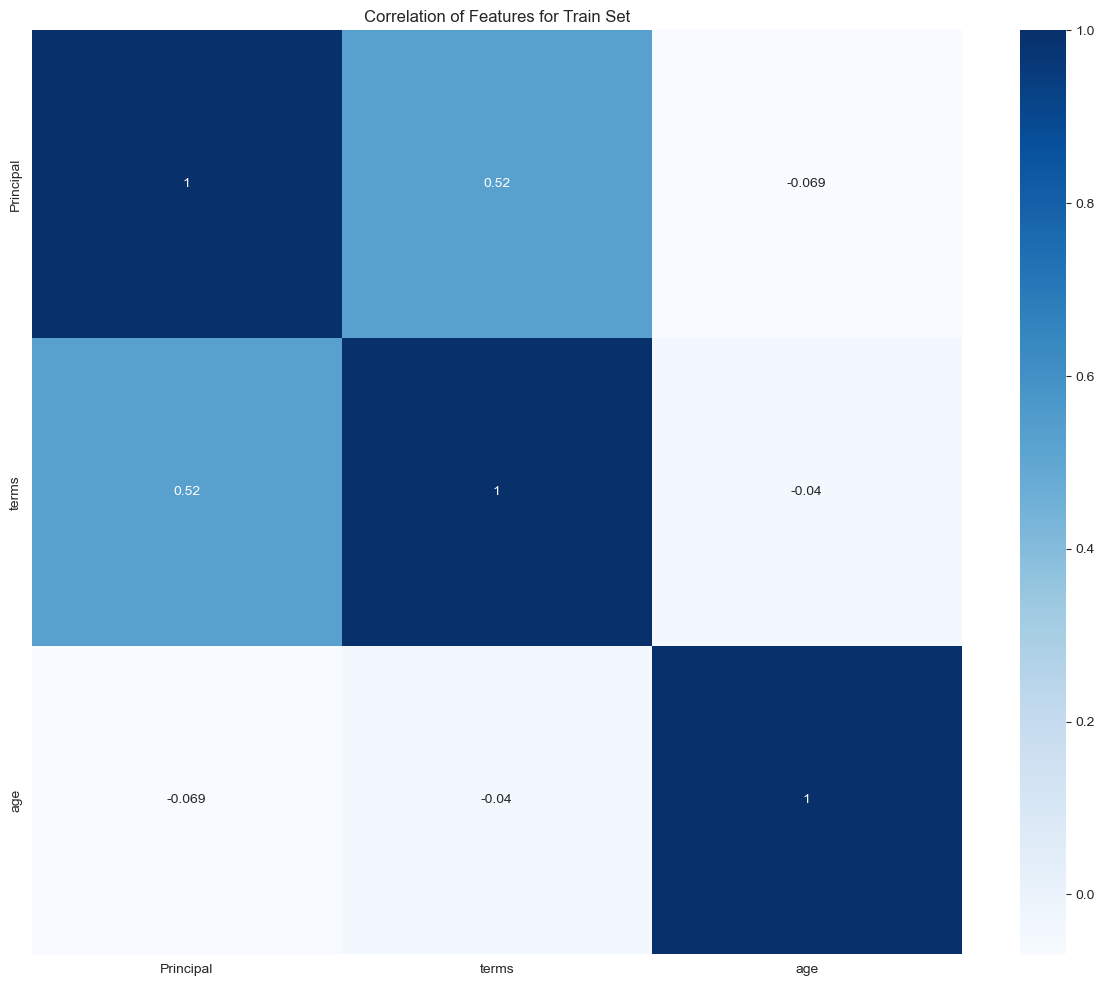

In [11]:
# HeatMap to check the potential or existing correlations before treating the data
plt.figure(figsize=(15, 12))
plt.title("Correlation of Features for Train Set")
sns.heatmap(df.corr(numeric_only=True), vmax=1.0, annot=True, cmap="Blues")
plt.show()

## Let's analyze and visualize the different features depending on whether or not customers repay the loan on time

***This is what we know from a first analysis:*** \
***We know that there are more men than women.*** \
***We know from the summary statistics that the minimum principal amount was 300 dollars and the maximum was 1000, and looking at the unique values we know that only 6 different principal amounts were requested.*** \
***We know that the minimum age registered was 18 years old and the maximum age was 51 years old, and looking at the unique values we know that 32 different ages were registered.***

***Let's go a little deeper with this knowledge.***

***Of the 400 clients, it seems that 300 paid their loans on time and the remaining 100 went into collection by missing the deadline, the classes are unbalanced.***

<AxesSubplot: ylabel='loan_status'>

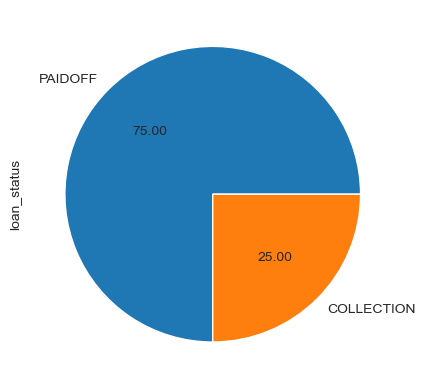

In [12]:
# proportion of the classes
df["loan_status"].value_counts().plot.pie(autopct="%0.2f")

***Of the 400 clients, we notice 337 (84.25%) are male and 63 (15.75%) are female.***

In [13]:
# numeric proportion
df["Gender"].value_counts()

male      337
female     63
Name: Gender, dtype: int64

In [14]:
# percentage proportion
df["Gender"].value_counts(normalize=True) * 100

male      84.25
female    15.75
Name: Gender, dtype: float64

***Of these 63 women, 84.13% paid on time and the other 15.87% did not pay on time. Of the 337 men, 73.29% paid on time and 26.71% did not pay on time.***

In [15]:
# create a table with the proportion in percentage of male and female between the two classes
groupby_gender = (
    df.groupby(["Gender"])["loan_status"].value_counts(normalize=True) * 100
)
groupby_gender.unstack(level=-1)

loan_status,COLLECTION,PAIDOFF
Gender,,
female,15.873016,84.126984
male,26.706231,73.293769


***Let us then look at the number of clients who, depending on gender and age, pay or do not pay the loans and at what ages do we see that there are more loan requests.***  \
***In this bar chart we can visually confirm that it is more usual for the loan to be in the name of a man, and there is a tendency for clients to choose/need higher principal values than lower ones.***

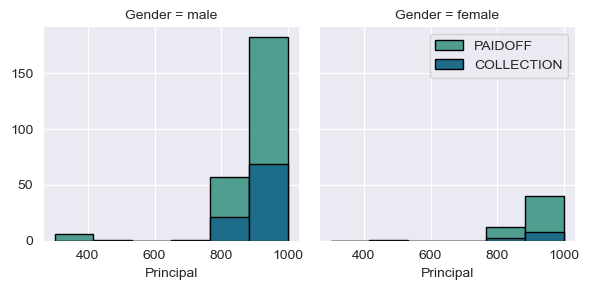

In [16]:
# plot the bar chart to visualize loan status trow ages split by gender
bins = np.linspace(df.Principal.min(), df.Principal.max(), 7)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="crest", col_wrap=2)
g.map(plt.hist, "Principal", bins=bins, ec="k")

g.axes[1].legend()
plt.show()

***Let us then look at the number of clients who, depending on their level of education and age, pay or not pay the loans and at what age there are more requests.***

In [17]:
# group by method, proportions of the education feature
group_by_edu = df.groupby("loan_status")["education"].value_counts()
group_by_edu.unstack(level=-1)

education,Bechalor,High School or Below,Master or Above,college
loan_status,,,,
COLLECTION,11,49,1,39
PAIDOFF,41,123,3,133


***We can state that most of the clients that requested loans with less than 30 years in majority are undergraduate, being also the 2 biggest groups of the 4 with 172 clients each.*** 

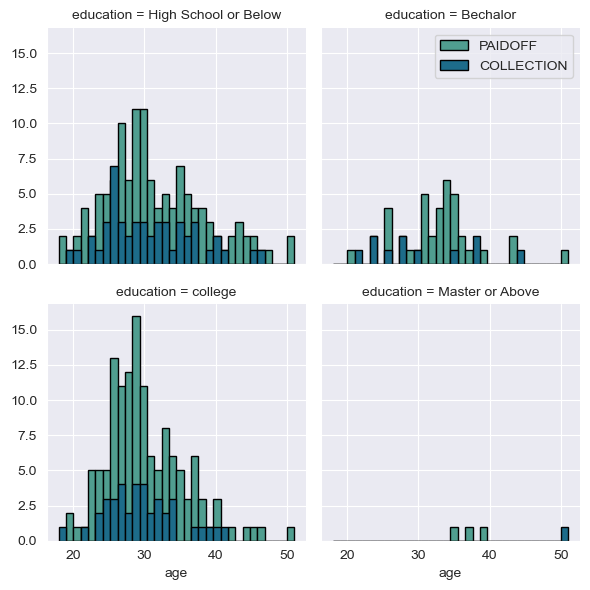

In [18]:
# plot the bar chart to visualize loan status trow ages split by education
bins = np.linspace(df.age.min(), df.age.max(), 33)
g = sns.FacetGrid(df, col="education", hue="loan_status", palette="crest", col_wrap=2)
g.map(plt.hist, "age", bins=bins, ec="k")

g.axes[1].legend()
plt.show()

***So let's look at the number of clients who, depending on the loan they take out and the term of the same, whether or not they repay the loans and what are the loan terms and amounts in which it is verified that there are more clients to pay or to enter into collection.*** \
***Through these observations below, we have already been able to observe a more concise correlation and that clients who usually ask for loans with shorter terms and lower amounts tend to pay it on time, in this case above 800 dollars and most of the clients ask for 800 and 1000 loans.***

In [19]:
# since there are so few different values for principal and terms, let's use a groupby
df.groupby(["terms", "Principal"], as_index=False)["loan_status"].value_counts(sort=True)

,terms,Principal,loan_status,count
0,7,300,PAIDOFF,6
1,7,500,PAIDOFF,1
2,7,800,PAIDOFF,1
3,7,900,PAIDOFF,1
4,7,1000,PAIDOFF,11
5,15,500,PAIDOFF,1
6,15,700,PAIDOFF,1
7,15,800,PAIDOFF,63
8,15,800,COLLECTION,22
9,15,900,PAIDOFF,1


In [20]:
# i'm showing the median to see if it differs a lot from the mean showed above
df.pivot_table(values="Principal", index="terms", aggfunc=[np.median])

,median
,Principal
terms,
7,1000
15,800
30,1000


In [21]:
# this pivot table is showing us the mean principal for each terms
df.pivot_table(
    values="Principal", index="loan_status", columns="terms", fill_value=0, margins=True
)

terms,7,15,30,All
loan_status,,,,
COLLECTION,0,892.682927,996.610169,954.00
PAIDOFF,750,893.700787,993.464052,935.00
All,750,893.452381,994.339623,939.75


In [22]:
# i'm showing the median to see if it differs a lot from the mean showed above
df.pivot_table(values="terms", index="Principal", aggfunc=[np.median])

,median
,terms
Principal,
300,7
500,11
700,15
800,15
900,11
1000,30


In [23]:
# this pivot table is showing us the mean terms for each principal
df.pivot_table(
    values="terms", index="loan_status", columns="Principal", fill_value=0, margins=True
)

Principal,300,500,700,800,900,1000,All
loan_status,,,,,,,
COLLECTION,0,0,0,15.652174,0,26.298701,23.850000
PAIDOFF,7,11,15,15.971014,11,24.690909,22.116667
All,7,11,15,15.891304,11,25.107744,22.550000


***We can see that customers in this week when they ask for terms of 7 days tend to ask for approximately 764 dollars, with 15 ask 881, and with 30 about 998, this means that with each passing day the value increases 7.79 dollars or 54.53 every 7. But it's only one week of data, we can't know for sure if this will be true with future clients.***

In [24]:
import statsmodels.formula.api as smf

# i used a regression model to analyze the relation between the principal and terms
reg_model = smf.ols("Principal ~ terms", data=df).fit()
terms = pd.DataFrame({"terms": [30, 15]})
predictions = terms.assign(prediction=reg_model.predict(terms))
display(predictions, reg_model.params)

,terms,prediction
0,30,997.791359
1,15,880.929562


Intercept    764.067764
terms          7.790787
dtype: float64

***In this scatter plot we can visually confirm that there is a tendency that usually clients who choose higher terms are getting higher principals, but we can also see that values under 800 only exist in loans with 7 and 15 days terms.***

<AxesSubplot: xlabel='terms', ylabel='Principal'>

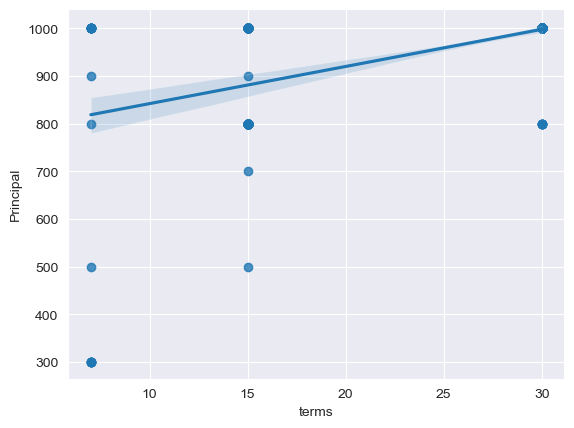

In [25]:
# plot with the fitted line and to visualize the relation between variables
sns.regplot(x="terms", y="Principal", data=df)

***So let's look at the number of clients who, depending on the day of the week they make the application and their age, whether or not they repay the loans and which days there are more requests.*** \
***Through this graph we have already managed to get a more concise correlation, we have been able to observe that clients who usually borrow at the weekend tend to be late in paying it.***

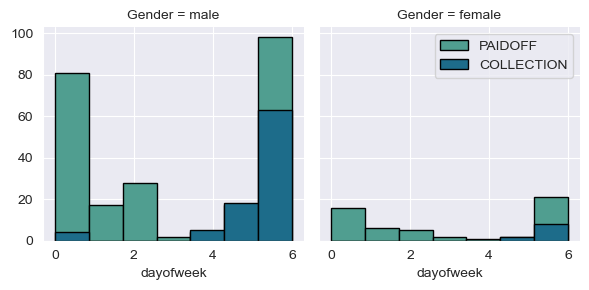

In [26]:
# extract which days of the week the loans were made
df["dayofweek"] = df["effective_date"].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)

g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="crest", col_wrap=2)
g.map(plt.hist, "dayofweek", bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

In [27]:
# the proportion of each day in the dataset
df["dayofweek"].sort_values().value_counts(normalize=True, sort=False) * 100

0    25.25
1     5.75
2     8.25
3     1.00
4     2.50
5     9.75
6    47.50
Name: dayofweek, dtype: float64

## Feature transformation and selection

***After the last observation, it is more appropriate to separate the weekend from the weekdays.***

In [28]:
# we use lambda function to create a new column
df["weekend"] = df["dayofweek"].apply(lambda x: 1 if (x > 3) else 0)
df.sample(10)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
188,PAIDOFF,1000,15,2016-09-12,2016-09-26,35,college,male,0,0
57,PAIDOFF,1000,30,2016-09-11,2016-10-10,43,Bechalor,male,6,1
203,PAIDOFF,800,15,2016-09-12,2016-09-26,36,High School or Below,male,0,0
382,PAIDOFF,1000,30,2016-09-13,2016-10-12,28,High School or Below,male,1,0
230,PAIDOFF,1000,30,2016-09-14,2016-10-13,42,High School or Below,male,2,0
284,COLLECTION,1000,30,2016-09-11,2016-10-10,30,High School or Below,female,6,1
104,PAIDOFF,1000,30,2016-09-11,2016-10-10,26,college,male,6,1
236,PAIDOFF,1000,30,2016-09-14,2016-10-13,30,Bechalor,male,2,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1
267,COLLECTION,1000,30,2016-09-10,2016-10-09,27,High School or Below,male,5,1


### Conversion of categorical features to numerical ones

***Feature gender, we can put it as a binary value***

In [29]:
# the models perform better with numbers than with strings
df["Gender"].replace(to_replace=["male", "female"], value=[0, 1], inplace=True)
df["Gender"].sample(5)

46     0
159    0
3      1
97     0
264    0
Name: Gender, dtype: int64

***Let's now make a new Dataframe with the definitive features that we want to feed our models.*** \
***We use a pandas "dummy" algorithm method to categorize the data in the education feature.***

In [30]:
# select the features to be used
df = df.drop(["effective_date", "due_date"], axis=1)

# one hot encode the features
df = pd.concat([df, pd.get_dummies(df["education"])], axis=1).drop(
    ["education"], axis=1
)
df.head(5)

,loan_status,Principal,terms,age,Gender,dayofweek,weekend,Bechalor,High School or Below,Master or Above,college
0,PAIDOFF,1000,30,45,0,3,0,0,1,0,0
1,PAIDOFF,1000,30,33,1,3,0,1,0,0,0
2,PAIDOFF,1000,15,27,0,3,0,0,0,0,1
3,PAIDOFF,1000,30,28,1,4,1,0,0,0,1
4,PAIDOFF,1000,30,29,0,4,1,0,0,0,1


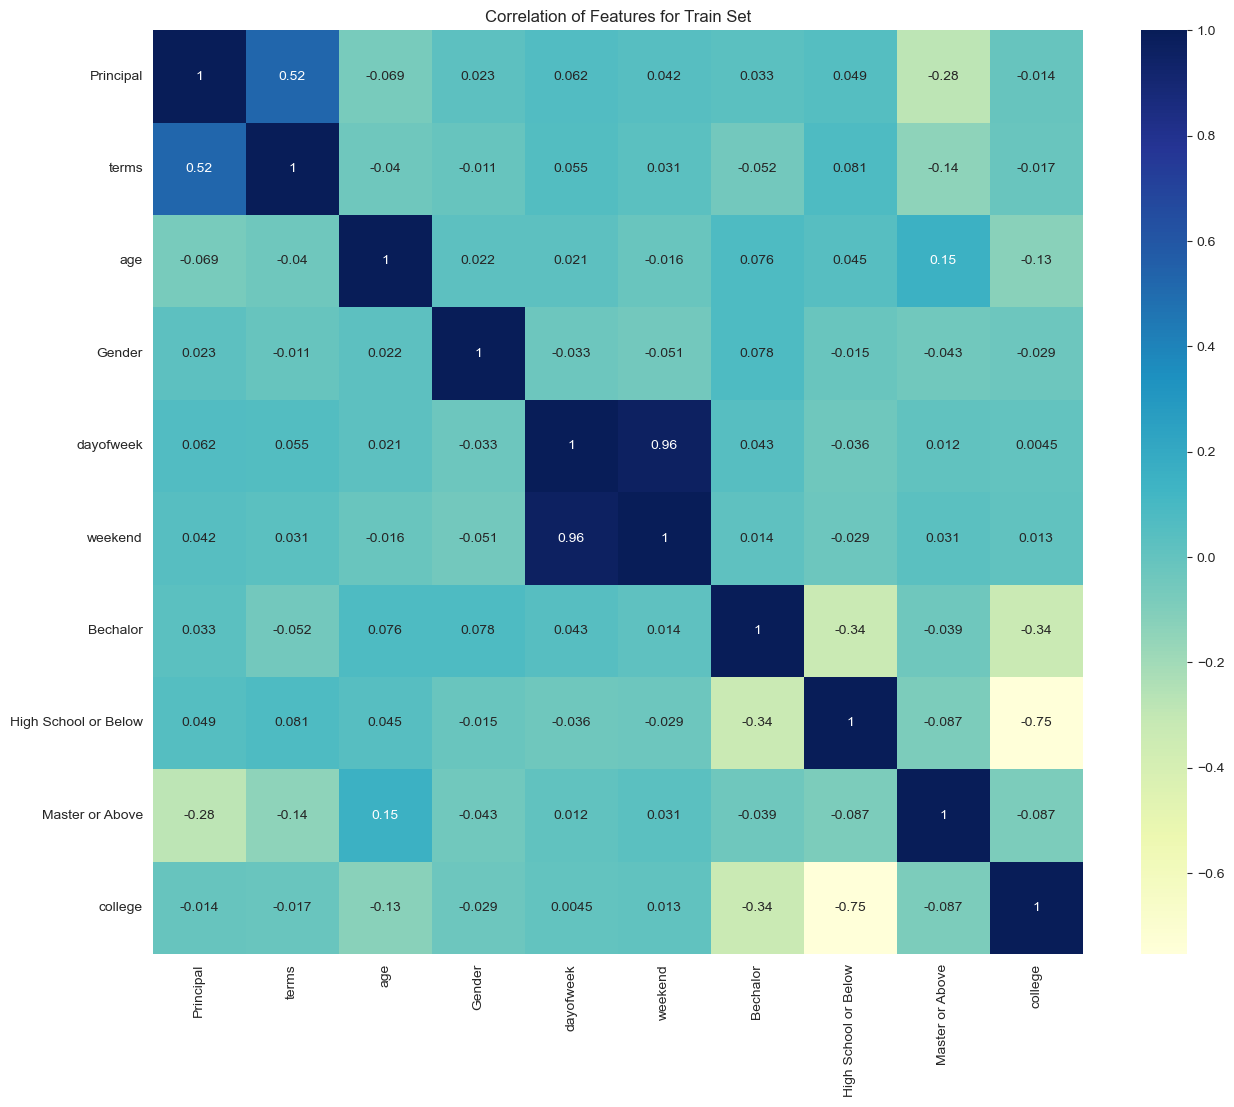

In [31]:
# HeatMap Correlation after all the preparation
plt.figure(figsize=(15, 12))
plt.title("Correlation of Features for Train Set")
sns.heatmap(df.corr(numeric_only=True), vmax=1.0, annot=True, cmap="YlGnBu")
plt.show()

In [32]:
# save the prepared DataFrame as a csv file
df.to_csv("loans_imbalanced.csv")